In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
import matplotlib
import matplotlib.pyplot as plt

In [2]:
mnist = fetch_openml("mnist_784", version=1, cache=True, data_home='./datasets/')

In [3]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
# mnist.DESCR
# mnist

In [4]:
X, y = mnist["data"], mnist["target"]
print(X.shape, y.shape)

(70000, 784) (70000,)


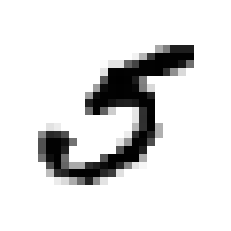

In [5]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [7]:
y[36000]

5

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [12]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)

In [16]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [17]:
sgd_clf.predict([some_digit])

array([ True])

In [18]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9671 , 0.9657 , 0.94485])

In [19]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9091 , 0.9125 , 0.90735])

In [20]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score

confusion_matrix(y_train_5, y_train_pred)

array([[53749,   830],
       [ 1617,  3804]])

In [22]:
precision_score(y_train_5, y_train_pred) # == 4333 / (4333 + 940)

0.8208890807078119

In [23]:
recall_score(y_train_5, y_train_pred) # == 4333 / (4333 + 1088)

0.701715550636414

In [25]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7566384883142716

In [27]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([850.36033573])

In [30]:
# threshold = 0
threshold = 20000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [31]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [32]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

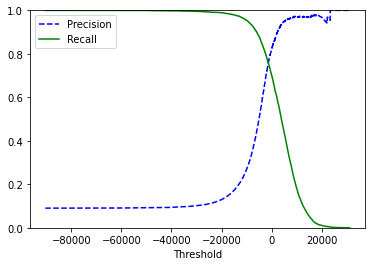

In [39]:
# Figure 3-4
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

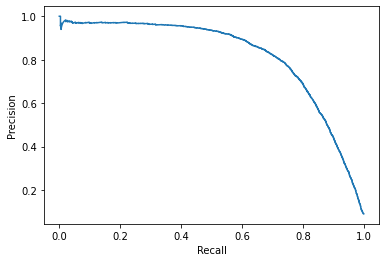

In [41]:
# Figure 3-5
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

In [50]:
y_train_pred_90 = (y_scores > 20000)
print(
    precision_score(y_train_5, y_train_pred_90),
    recall_score(y_train_5, y_train_pred_90)
)

0.967741935483871 0.011068068622025456


# ROC Curve

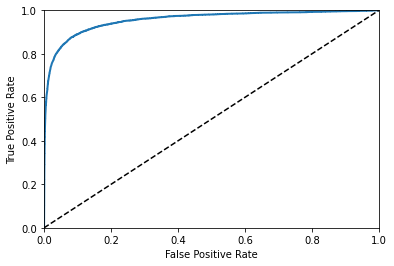

In [57]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

In [58]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9562827445023419

In [107]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_probas_forest

array([[1.  , 0.  ],
       [0.89, 0.11],
       [0.91, 0.09],
       ...,
       [0.99, 0.01],
       [1.  , 0.  ],
       [0.99, 0.01]])

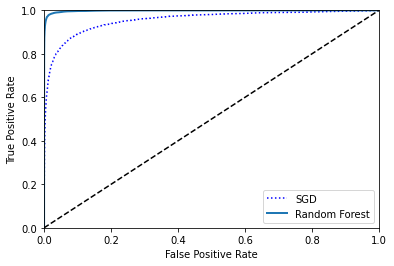

In [86]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="bottom right")
plt.show()

In [87]:
roc_auc_score(y_train_5, y_scores_forest)

0.9982551570420176

In [93]:
y_scores_forest
y_train_pred_forest = (y_scores_forest > 0.5)
print(
    precision_score(y_train_5, y_train_pred_forest),
    recall_score(y_train_5, y_train_pred_forest)
)

0.9910023017367651 0.8736395498985428


# Multiclass Classification

In [94]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5], dtype=int8)

In [96]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[ -5802.72187977, -24394.42424083,  -8807.77734349,
         -1747.61992024, -20526.37496306,    529.69184689,
        -27167.76998517, -26818.82179792,  -8180.79247324,
        -15667.17055031]])

In [97]:
np.argmax(some_digit_scores)

5

In [98]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [100]:
sgd_clf.classes_[5]

5

In [108]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])


array([5], dtype=int8)

In [109]:
len(ovo_clf.estimators_)

45

In [110]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=int8)

In [111]:
forest_clf.predict_proba([some_digit])

array([[0.04, 0.02, 0.  , 0.03, 0.  , 0.9 , 0.01, 0.  , 0.  , 0.  ]])

In [112]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.8867 , 0.88645, 0.8728 ])

In [113]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.90185, 0.90605, 0.89735])